In [1]:
#--------------------------------
## IMPORTS
#--------------------------------
import sys
import os

# set the path to find the modules
sys.path.insert(0, '../005_src/') #use relative path
#os.chdir("../005_src")

from config import *

----------------------------------------
Packages import successful
Variables import successful
Helper Functions import successful
Functions import successful
Functions xml import successful
Functions graph import successful
Functions GCN import successful
Functions Plotting import successful
Functions Data Adjustments import successful
Custom loss imported
Functions Plotting import successful
----------------------------------------
root directory: /storage/remote/atcremers50/ss21_multiagentcontrol/
input directory: /storage/remote/atcremers50/ss21_multiagentcontrol/004_data/
output directory: /storage/remote/atcremers50/ss21_multiagentcontrol/006_model_output/
----------------------------------------

----------------------------------------
root directory: /storage/remote/atcremers50/ss21_multiagentcontrol/
input directory: /storage/remote/atcremers50/ss21_multiagentcontrol/004_data/
output directory: /storage/remote/atcremers50/ss21_multiagentcontrol/006_model_output/
-------------

In [2]:
device = cudaOverview()

CUDA not available, running on cpu


In [3]:
from _03_Networks.GCN_005.GCN_model_005 import *
check_import()
from _03_Networks.GCN_005.GCN_trainer_005 import *
this_GCN, ts = check_import()
this_date = get_date()

imported model: GCN_005 at 20h32m49s
edges_attr=True
imported trainer: GCN_005 at 20h32m49s


In [4]:
##================================
## INIT SAVING PATHS
##================================

MODEL_OUTPUT_PATH = os.path.join(OUTPUT_DIR,f"{this_GCN}/")
MODEL_OUTPUT_PATH_TODAY = os.path.join(MODEL_OUTPUT_PATH,f"{this_date}{ts}/")
print (MODEL_OUTPUT_PATH_TODAY)
if not os.path.exists(MODEL_OUTPUT_PATH_TODAY):
    Path(MODEL_OUTPUT_PATH_TODAY).mkdir(parents=True, exist_ok=True)
    
dict_text_output = {}

/storage/remote/atcremers50/ss21_multiagentcontrol/006_model_output/GCN_005/20210710-20h32m49s/


In [5]:
##================================
## MODEL VAR
##================================

random_seed = 42
train_size = 0.9  
batch_size = 64 # maybe 100 is too much...

Nepochs =1000
savestat = True
save_every = int(Nepochs/2) # temp pkl, pt, png, can delete after final is stored
transformstat = False
plotstat = True
printstat = True

training_losses = []
validation_losses = []
lr_rates = []

# create keys and values for all the stuff that you want later on print out in txt files
dict_text_output.update({
                    'run_time':ts,
                    'model': this_GCN,
                    'random_seed': random_seed,
                    'train_size':train_size,
                    'batch_size': batch_size,
                    'Nepochs': Nepochs,
                    'save_every':save_every, 
                    'transformstat': transformstat,
                    'plotstat': plotstat,
                    'printstat' : printstat
    
                    })


In [6]:
##================================
## LOAD DATA
##================================
input_file_name = "20210710-13h21m45s_timesteps15000_ec3500_em7000"
dict_text_output["input_file_name"] = input_file_name

txt_data = os.path.join(GCN_INPUT_FOLDER,f"{input_file_name}.txt")
dict_text_data = read_txt_data(txt_data)

dict_text_output['input_file_name'] = input_file_name

In [7]:
##if plotstat:
#path_figure = read_txt_data(dict_text_data['info_input_df'])["path_figure"]
#Image(open(f'{path_figure}','rb').read())

In [8]:
##if plotstat:
#path_GIF = dict_text_data["path_GIF"]
#Image(open(f'{path_GIF}','rb').read())

The function "" select only the rows marked with "training row" True.


In [9]:
df_all,df_selected = select_rows_from_data(input_file_name,drop_col = True)
df_all.loc[15]

data_x                [[180.0, 19.49, 1.0], [0.0, 16.23, 1.0], [90.0...
data_pos                [[98.4, 29.75], [101.6, 107.05], [31.88, 98.4]]
data_edges                                       [[0, 0, 1], [1, 2, 2]]
data_edges_renamed                               [[0, 0, 1], [1, 2, 2]]
data_y                      [[101.6, 140.07, 0.0], [55.94, 98.4, 90.0]]
data_edges_attr                                         [2.0, 1.9, 2.2]
training_row                                                      False
Name: 15, dtype: object

In [10]:
len(df_selected), len(df_all)

(10105, 14995)

In [11]:
df_input = df_selected

In [12]:
dict_text_data.keys()

dict_keys(['max_num_veh', 'date', 'time', 'usr', 'env', 'path_input_df', 'info_input_df', 'sim_duration_timesteps', 'edge_creation_radius', 'edge_maintenance_radius', 'edge_weights_option', 'predict_after_timesteps', 'savestat', 'delete_temporary_files', 'plotstat', 'path_GCN_input', 'path_GIF'])

In [13]:
# get the max number of vehicle per time step M
# input data_x [Mx3]
# input data_pos [Mx2]
# output y [Mx3]
M = int(dict_text_data['max_num_veh'])
sim_duration_timesteps = dict_text_data['sim_duration_timesteps']
print (f"max_num_veh: {M}")
print (f"sim_duration_timesteps: {sim_duration_timesteps}")



max_num_veh: 10
sim_duration_timesteps: 15000


In [14]:
##================================
## TRAIN AND VALIDATION 
##================================
c = df_input.index.tolist()
train_frames, valid_frames = train_test_split(
                                c,
                                random_state=random_seed,
                                train_size=train_size,
                                shuffle=True)

valid_frames, test_frames = train_test_split(
                                valid_frames,
                                random_state=random_seed,
                                train_size=0.9,
                                shuffle=True)

dict_text_output['num_rows_training'] = len(train_frames)
dict_text_output['num_rows_validation'] = len(valid_frames)
dict_text_output['num_rows_test'] = len(test_frames)

In [15]:
##================================
## VARIATIONS
##================================

exclude_yaw = True
paddingstat = False
concatenatestat = True

if concatenatestat:
    size_input = 4
    print (f"Input: concatenation(data_x,data_pos) [bacth_size,{size_input}]")
else:
    size_input = 2
    print (f"Input: concatenation(data_x) [bacth_size,{size_input}]")
if exclude_yaw:
    size_output = 2
    print (f"Predicting: X, Y [bacth_size,{size_output}]")
else:
    size_output = 3
    print (f"Predicting: X, Y, Yaw [bacth_size,{size_output}]")
    
dict_text_output['exclude_yaw'] = exclude_yaw
dict_text_output['concatenatestat'] = concatenatestat
dict_text_output['paddingstat'] = paddingstat
dict_text_output['size_input'] = f"[{batch_size,size_input}]"
dict_text_output['size_output'] = f"[{batch_size,size_output}]"

Input: concatenation(data_x,data_pos) [bacth_size,4]
Predicting: X, Y [bacth_size,2]


In [16]:
##================================
## CREATING THE DATASET
##================================
print (f"> CREATING THE DATASET")
dataset_train = Dataset_1(
                     df_input,
                     train_frames,
                     #transform=transforms_training,
                     M = M,
                     printstat = False,
                     concatenatestat = concatenatestat,
                     paddingstat = paddingstat,
                     exclude_yaw = exclude_yaw
                     )
dataset_val = Dataset_1(
                     df_input,
                     valid_frames,
                     M = M,
                     concatenatestat = concatenatestat,
                     paddingstat = paddingstat,
                     exclude_yaw = exclude_yaw
                     )
dataset_test = Dataset_1(
                     df_input,
                     test_frames,
                     M = M,
                     concatenatestat = concatenatestat,
                     paddingstat = paddingstat,
                     exclude_yaw = exclude_yaw
                     )
printif(dataset_train, n = 10)

  0%|          | 16/9094 [00:00<00:59, 153.43it/s]

> CREATING THE DATASET


100%|██████████| 102/102 [00:00<00:00, 162.93it/s]

0) Data(edge_attr=[45], edge_index=[2, 45], pos=[10, 2], x=[10, 4], y=[10, 2])
1) Data(edge_attr=[45], edge_index=[2, 45], pos=[10, 2], x=[10, 4], y=[10, 2])
2) Data(edge_attr=[45], edge_index=[2, 45], pos=[10, 2], x=[10, 4], y=[10, 2])
3) Data(edge_attr=[45], edge_index=[2, 45], pos=[10, 2], x=[10, 4], y=[10, 2])
4) Data(edge_attr=[45], edge_index=[2, 45], pos=[10, 2], x=[10, 4], y=[10, 2])
...
9089) Data(edge_attr=[45], edge_index=[2, 45], pos=[10, 2], x=[10, 4], y=[10, 2])
9090) Data(edge_attr=[45], edge_index=[2, 45], pos=[10, 2], x=[10, 4], y=[10, 2])
9091) Data(edge_attr=[45], edge_index=[2, 45], pos=[10, 2], x=[10, 4], y=[10, 2])
9092) Data(edge_attr=[45], edge_index=[2, 45], pos=[10, 2], x=[10, 4], y=[10, 2])
9093) Data(edge_attr=[45], edge_index=[2, 45], pos=[10, 2], x=[10, 4], y=[10, 2])


In [17]:
dataset_train[0]

Data(edge_attr=[45], edge_index=[2, 45], pos=[10, 2], x=[10, 4], y=[10, 2])

In [18]:
##================================
# DataLoader
##================================
train_loader = DataLoader(dataset_train, batch_size=10, shuffle=False)
val_loader = DataLoader(dataset_val, batch_size=10, shuffle=False)
test_loader = DataLoader(dataset_test, batch_size=10, shuffle=False)

In [19]:
print(f"{len(train_loader.dataset)=}")
print(f"{len(val_loader.dataset)=}")
print(f"{len(test_loader.dataset)=}")

len(train_loader.dataset)=9094
len(val_loader.dataset)=909
len(test_loader.dataset)=102


In [20]:
##================================
## TRANSFORMATIONS
##================================
if transformstat: 
    # not implemented, not needed i think
    transforms_training = None
    transforms_validation = None
else:
    transforms_training = None
    transforms_validation = None

## GCN

In [21]:
model = GCN(num_input_features=size_input,
            num_output_features =size_output,
            random_seed = random_seed,
            hc_1 = 16,
            #hc_2 = 32
           )

criterion = torch.nn.MSELoss()  # Define loss criterion for regression
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)#, weight_decay=5e-4)  # Define optimizer.
#optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.6)# optimizer


In [22]:
print(model)
dict_text_output['model_architecture'] = model
dict_text_output['criterion']= criterion
dict_text_output['optimizer']= optimizer

GCN(
  (conv1): GCNConv(4, 16)
  (conv2): GCNConv(16, 2)
)


In [23]:
from statistics import mean

In [24]:
mean([1,4])

2.5

In [25]:
training_losses = []
validation_losses = []

In [26]:
# run
if Nepochs <= 100:
    for epoch in (range(1, Nepochs+1)):
        epoch_training_losses = []
        epoch_training_losses,description,model_path = train(
                                                        model,
                                                        optimizer,
                                                        criterion,
                                                        train_loader,
                                                        epoch_training_losses,
                                                        printstat= True,

                                                        savestat = savestat,
                                                        Nepochs = Nepochs,
                                                        save_every = save_every,
                                                        epoch_num = epoch,
                                                        save_dir = MODEL_OUTPUT_PATH_TODAY,
                                                        model_name = this_GCN,
                                                        date = this_date,
                                                        ts = ts,
                                              )
        epoch_loss = mean(epoch_training_losses)
        training_losses.append(epoch_loss)
        print(f'Epoch: {epoch}, Loss: {epoch_loss}')
else: 
    for epoch in tqdm(range(1, Nepochs)):
        epoch_training_losses = []
        epoch_training_losses,description,model_path = train(
                                                        model,
                                                        optimizer,
                                                        criterion,
                                                        train_loader,
                                                        epoch_training_losses,
                                                        printstat= printstat,

                                                        savestat = savestat,
                                                        Nepochs = Nepochs,
                                                        save_every = save_every,
                                                        epoch_num = epoch,
                                                        save_dir = MODEL_OUTPUT_PATH_TODAY,
                                                        model_name = this_GCN,
                                                        date = this_date,
                                                        ts = ts,
            
                                          )
        epoch_loss = mean(epoch_training_losses)
        training_losses.append(epoch_loss)
        

 50%|█████     | 500/999 [15:44<15:53,  1.91s/it]

Saved model in /storage/remote/atcremers50/ss21_multiagentcontrol/006_model_output/GCN_005/20210710-20h32m49s/20210710-20h32m49s500_TEMP_GCN_005.pt


100%|██████████| 999/999 [31:34<00:00,  1.90s/it]


In [35]:
model_path

## Saving 

Plot saved in /storage/remote/atcremers50/ss21_multiagentcontrol/006_model_output/GCN_005/20210710-20h32m49s/None_training_loss_plot.png


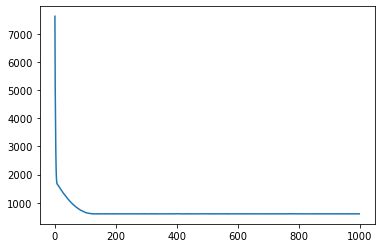

In [28]:
figsize = (10,10)
plt.plot(range(0,len(training_losses)), training_losses)
new_png = f"{description}_training_loss_plot.png"
new_png_path = os.path.join(MODEL_OUTPUT_PATH_TODAY,new_png)
plt.savefig(new_png_path)
print (f"Plot saved in {new_png_path}")

In [29]:
tloss_descr = f"{description}_training_loss"
tloss_path = os.path.join(MODEL_OUTPUT_PATH_TODAY,tloss_descr)
with open(f'{tloss_path}.pkl', 'wb') as f:
    pkl.dump(mean(epoch_training_losses), f)
    
dict_text_output['tloss_path']= tloss_path
dict_text_output['final_loss']= training_losses[-1]

In [30]:
dict_text_output_descr = f"{description}_training_parameters"
dict_text_output_path = os.path.join(MODEL_OUTPUT_PATH_TODAY,dict_text_output_descr)
with open(f'{dict_text_output_path}.pkl', 'wb') as handle:
    pkl.dump(dict_text_output, handle, protocol=pkl.HIGHEST_PROTOCOL)
    
TXT_OUTPUT = f'{dict_text_output_path}.txt'
with open(TXT_OUTPUT, 'w') as filehandle:
    for k,v in dict_text_output.items():
        filehandle.write(f'{k}: {v}\n')
    filehandle.close()

In [31]:
# unpickle to check 
reloaded_dict = pkl.load(open(f'{dict_text_output_path}.pkl',"rb"))
reloaded_dict

{'run_time': '20h32m49s',
 'model': 'GCN_005',
 'random_seed': 42,
 'train_size': 0.9,
 'batch_size': 64,
 'Nepochs': 1000,
 'save_every': 500,
 'transformstat': False,
 'plotstat': True,
 'printstat': True,
 'input_file_name': '20210710-13h21m45s_timesteps15000_ec3500_em7000',
 'num_rows_training': 9094,
 'num_rows_validation': 909,
 'num_rows_test': 102,
 'exclude_yaw': True,
 'concatenatestat': True,
 'paddingstat': False,
 'size_input': '[(64, 4)]',
 'size_output': '[(64, 2)]',
 'model_architecture': GCN(
   (conv1): GCNConv(4, 16)
   (conv2): GCNConv(16, 2)
 ),
 'criterion': MSELoss(),
 'optimizer': Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     eps: 1e-08
     lr: 0.001
     weight_decay: 0
 ),
 'tloss_path': '/storage/remote/atcremers50/ss21_multiagentcontrol/006_model_output/GCN_005/20210710-20h32m49s/None_training_loss',
 'final_loss': 604.6893647581667}

In [32]:
np.set_printoptions(suppress=True)
for data in dataset_val[:1]:
    print ("--------------")
    print ("\nINPUT DATA_POS,DATA_X")
    print (np.around(data.x.detach().numpy(),2))
    print ("\nTARGET DATA_Y")
    print (data.y.detach().numpy())
    print ("\nPREDICTIONS")
    print (model(data.x, data.edge_index,data.edge_attr).detach().detach().numpy())

--------------

INPUT DATA_POS,DATA_X
[[101.6   91.8    0.     0.  ]
 [101.6   84.3    0.     0.  ]
 [ 98.4  108.2  180.     0.  ]
 [108.2  101.6  270.     0.  ]
 [ 55.05 101.6  270.    11.9 ]
 [ 91.64  98.4   90.     0.18]
 [ 98.4  115.72 180.     0.12]
 [ 78.94  98.4   90.     8.87]
 [ 98.4  183.12 180.     6.29]
 [190.21 101.6  270.     3.01]]

TARGET DATA_Y
[[101.6   94.3 ]
 [101.6   84.3 ]
 [ 98.4  106.46]
 [108.2  101.6 ]
 [ 24.27 101.6 ]
 [ 91.8   98.4 ]
 [ 98.4  115.7 ]
 [ 84.08  98.4 ]
 [ 98.4  165.77]
 [180.17 101.6 ]]

PREDICTIONS
[[ 94.42789  100.32282 ]
 [ 94.350204 102.61551 ]
 [ 94.350624 102.60318 ]
 [ 94.355125 102.47026 ]
 [ 94.412834 100.76711 ]
 [ 94.36044  102.313416]
 [ 94.38745  101.51627 ]
 [ 94.39501  101.29319 ]
 [ 94.42498  100.40877 ]
 [ 94.42398  100.43811 ]]


## Plot results

In [36]:
# load model
# defining the model
load_model = GCN(num_input_features=size_input,
            num_output_features =size_output,
            random_seed = random_seed,
            hc_1 = 16,
           )

#load_path = "/storage/remote/atcremers50/ss21_multiagentcontrol/006_model_output/GCN_004/20210710-17h55m10s/20210710-17h55m10s100_FINAL_GCN_004.pt"
load_path = "/storage/remote/atcremers50/ss21_multiagentcontrol/006_model_output/GCN_005/20210710-20h32m49s/20210710-20h32m49s500_TEMP_GCN_005.pt"
load_model.load_state_dict(torch.load(load_path))
load_model.eval()



GCN(
  (conv1): GCNConv(4, 16)
  (conv2): GCNConv(16, 2)
)

In [ ]:
def plot_results_model(
                   model,
                   dataset,
                   start_from = 0,
                   end_at = 10,
                   edges_attr = True,
                   figsize = (10,10),
                   plot_intention = True, 
                  ):
    figsize = figsize
    for i,data in enumerate(dataset[start_from:end_at]):
        #print ("--------------")
        #print (data.x)
        #print (data.y)
        IDX = i+start_from
        if edges_attr:
            pred = model(data.x,
                         data.edge_index,
                         data.edge_attr
                        ).detach().numpy()
        else: 
            pred = model(data.x,
                         data.edge_index,
                        ).detach().numpy()            
         
        ## INITIALIZE FIGURE
        fig, ax = plt.subplots(figsize= figsize) 
        #cmap = list(sns.color_palette("Paired",len(pred)).as_hex())
            
        ## PLOT INPUT
        # print (pred)
        X,Y = [], []
        INTENTION = []
        for e in data.x.detach().numpy():
            X.append(e[0])
            Y.append(e[1])
            INTENTION.append(e[-1])
            
        #select colors
        ax.set_title(f"2D map of data {IDX}");
        ax.set_xlabel("X");
        ax.set_ylabel("Y"); 
        ax.scatter(X,Y, c ="orange",alpha = 0.8,s = 300, label= "initial positions at time t")

        for i,x in enumerate(X):
            ax.annotate(str(i), (x, Y[i]), ha='center', va='center', size=14)  
            if plot_intention:
                ax.annotate(intention_dict_1[INTENTION[i]], (x+5, Y[i]+5), ha='center', va='center', size=10 , c = "red")  
            
            
        ## PLOT MODEL PREDICTIONS
        # print (pred)
        X,Y = [], []
        for e in pred:
            X.append(e[0])
            Y.append(e[1])

        #select colors
        ax.set_title(f"2D map of timestep {IDX}");
        ax.set_xlabel("X");
        ax.set_ylabel("Y"); 
        ax.scatter(X,Y, c ="lightblue",alpha = 0.5, s = 300, label= "predicted positions at time t+2")

        for i,x in enumerate(X):
            ax.annotate(str(i), (x, Y[i]), ha='center', va='center', size=14)

        ## PLOT TARGETS
        X,Y = [], []
        for e in data.y.detach().numpy():
            X.append(e[0])
            Y.append(e[1])

        ax.scatter(X,Y, c ="lightgreen",alpha = 0.5,s = 500, label = "target positions at time t+2")
        for i,x in enumerate(X):
            ax.annotate(str(i), (x, Y[i]), ha='center', va='center', size=14)
        
        
        ax.set_xlim(0,200)
        ax.set_ylim(0,200)
        ax.legend()
        ax.grid()

        plt.show()

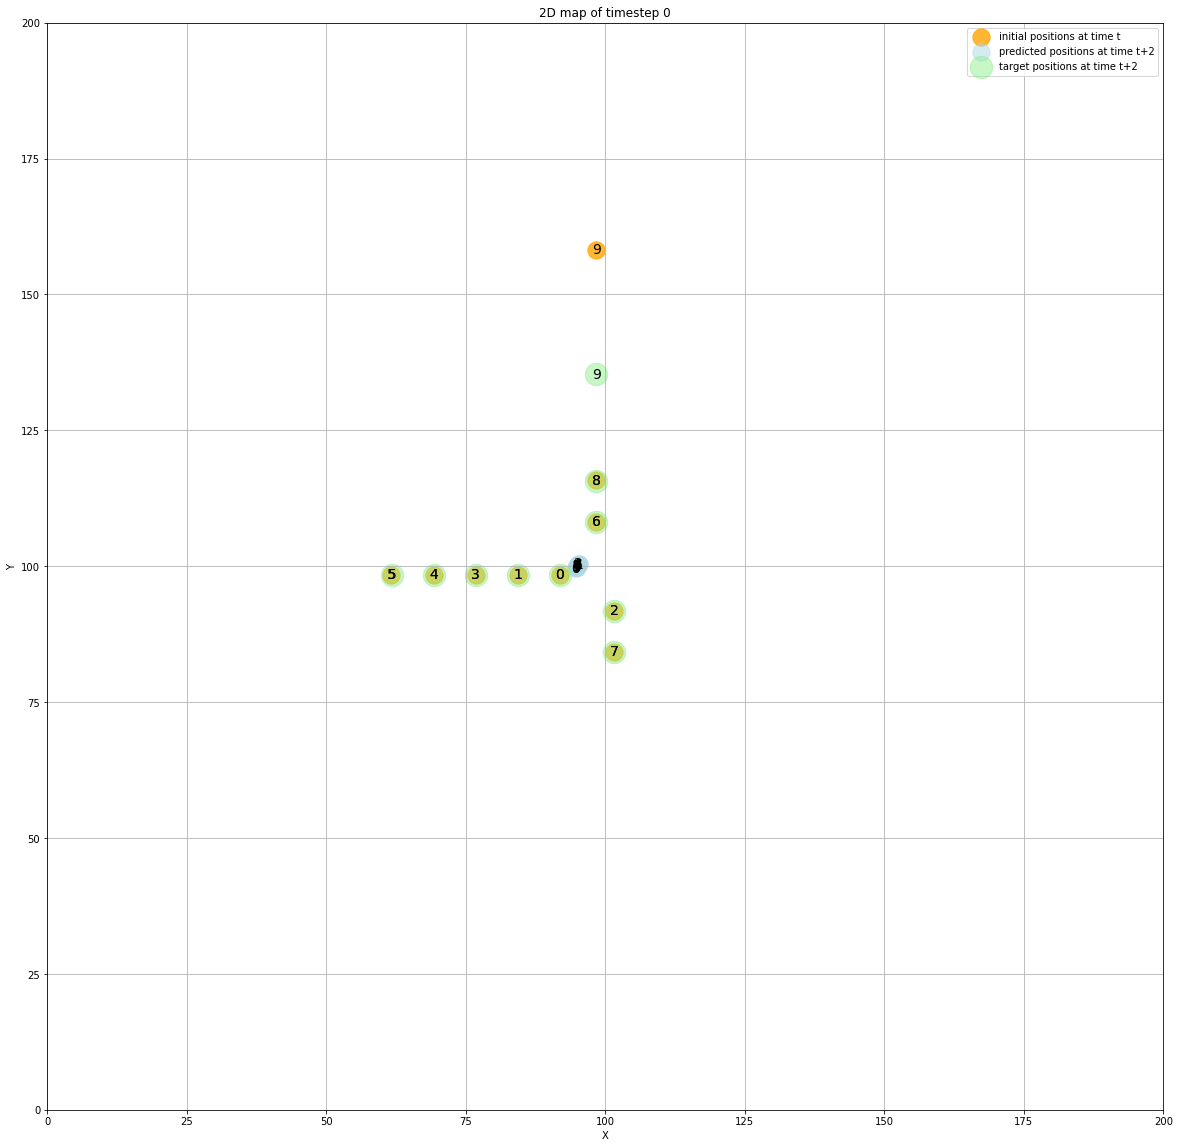

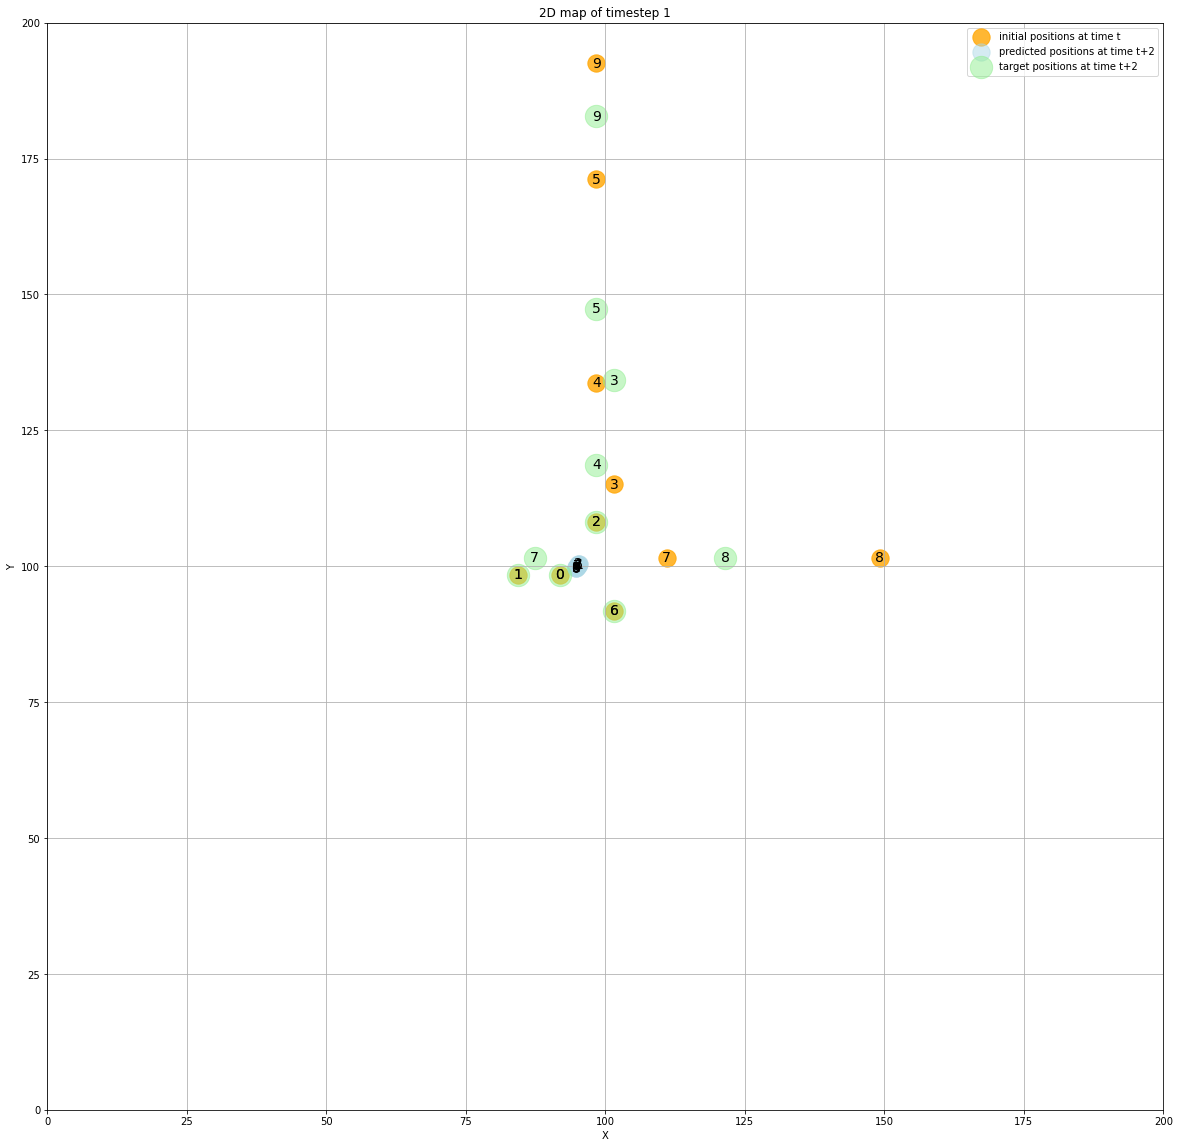

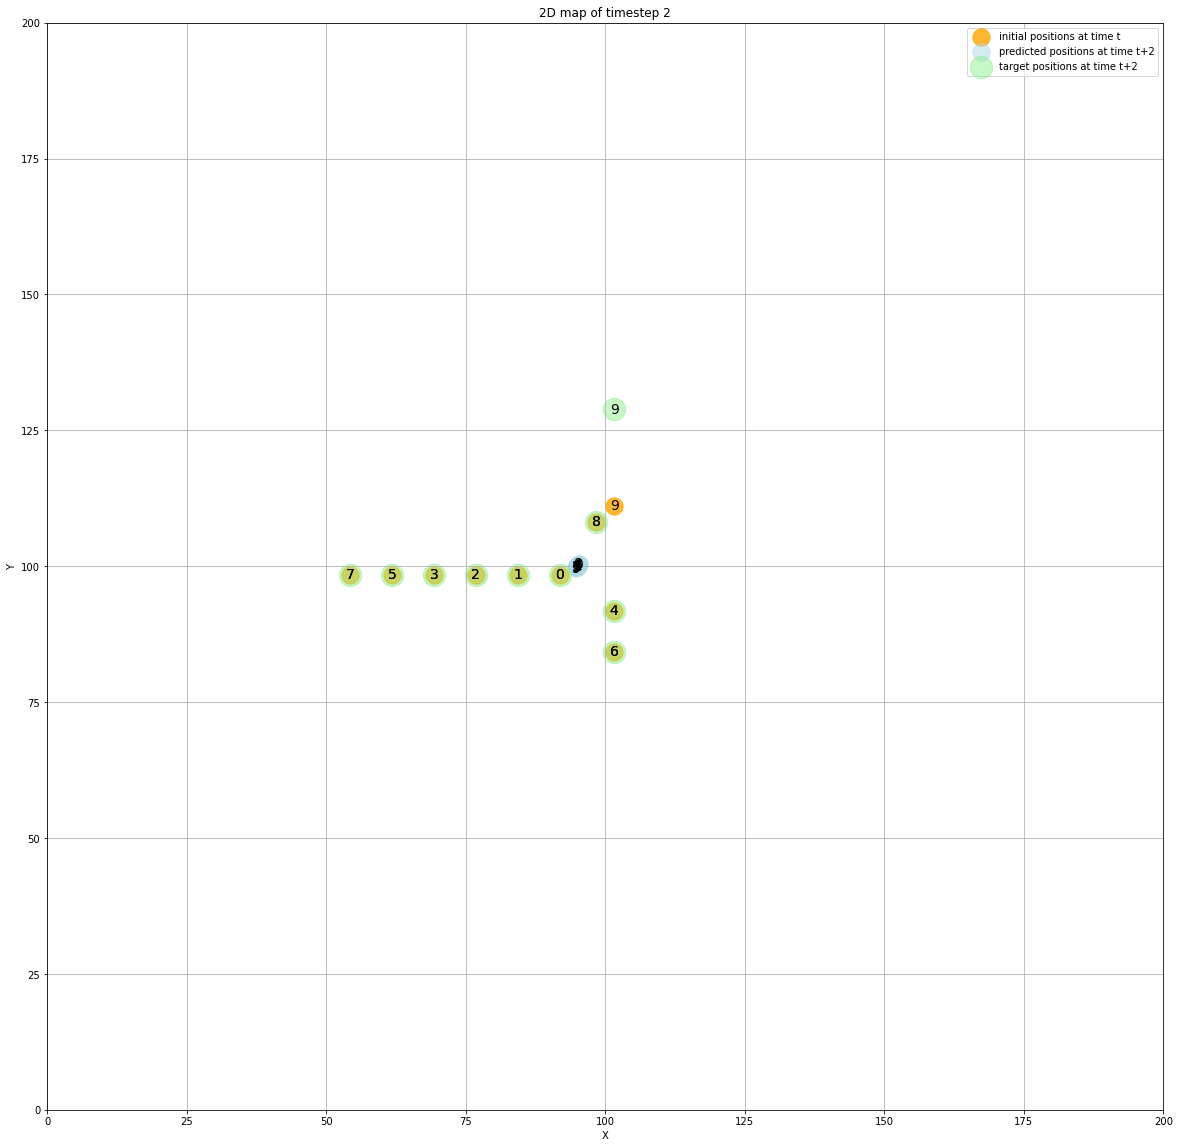

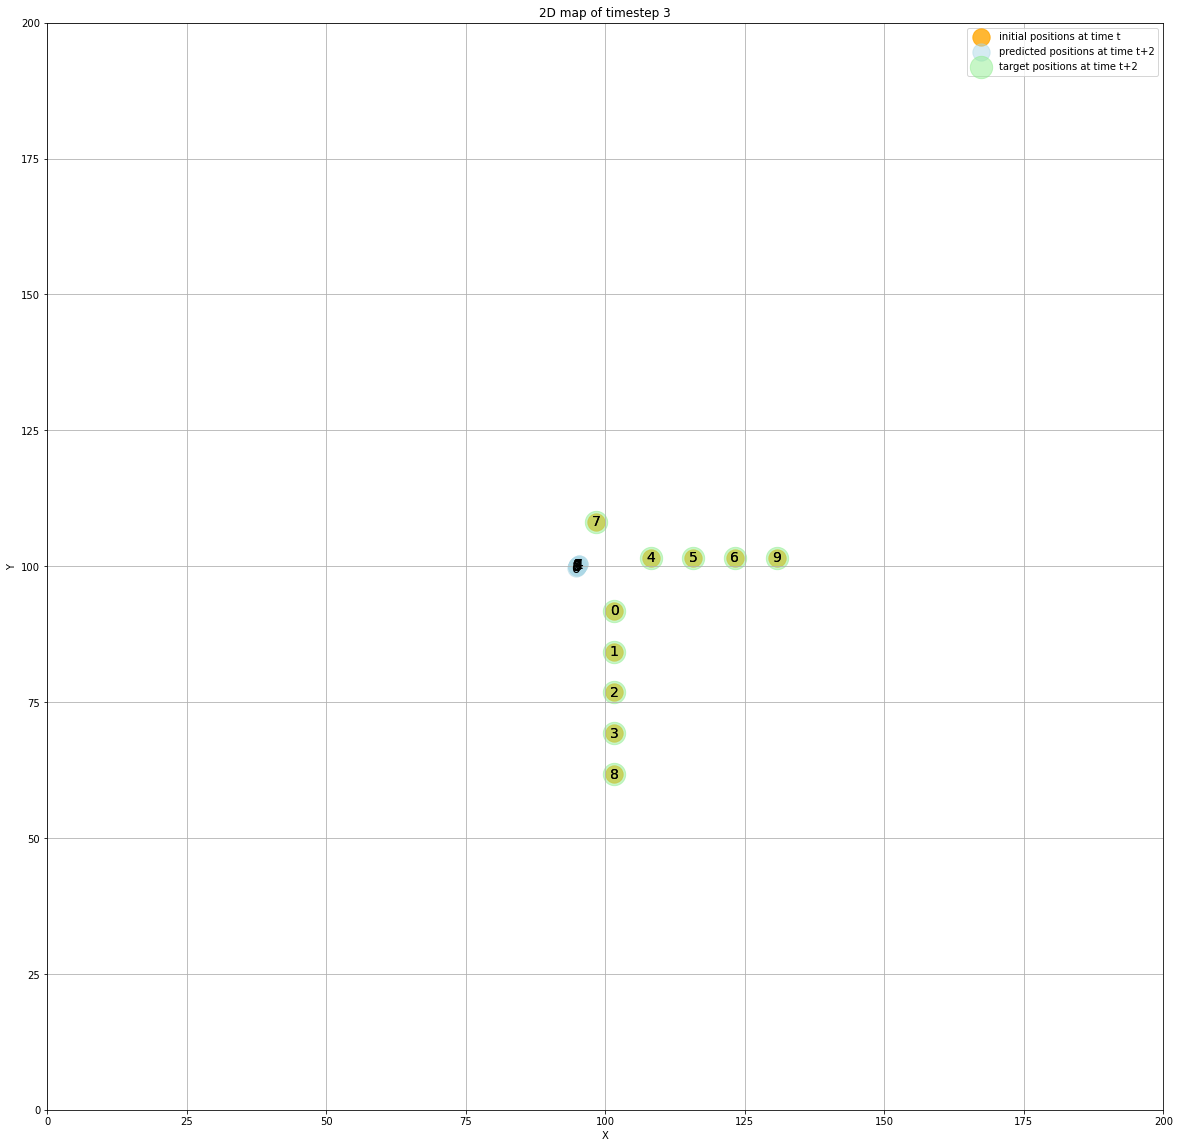

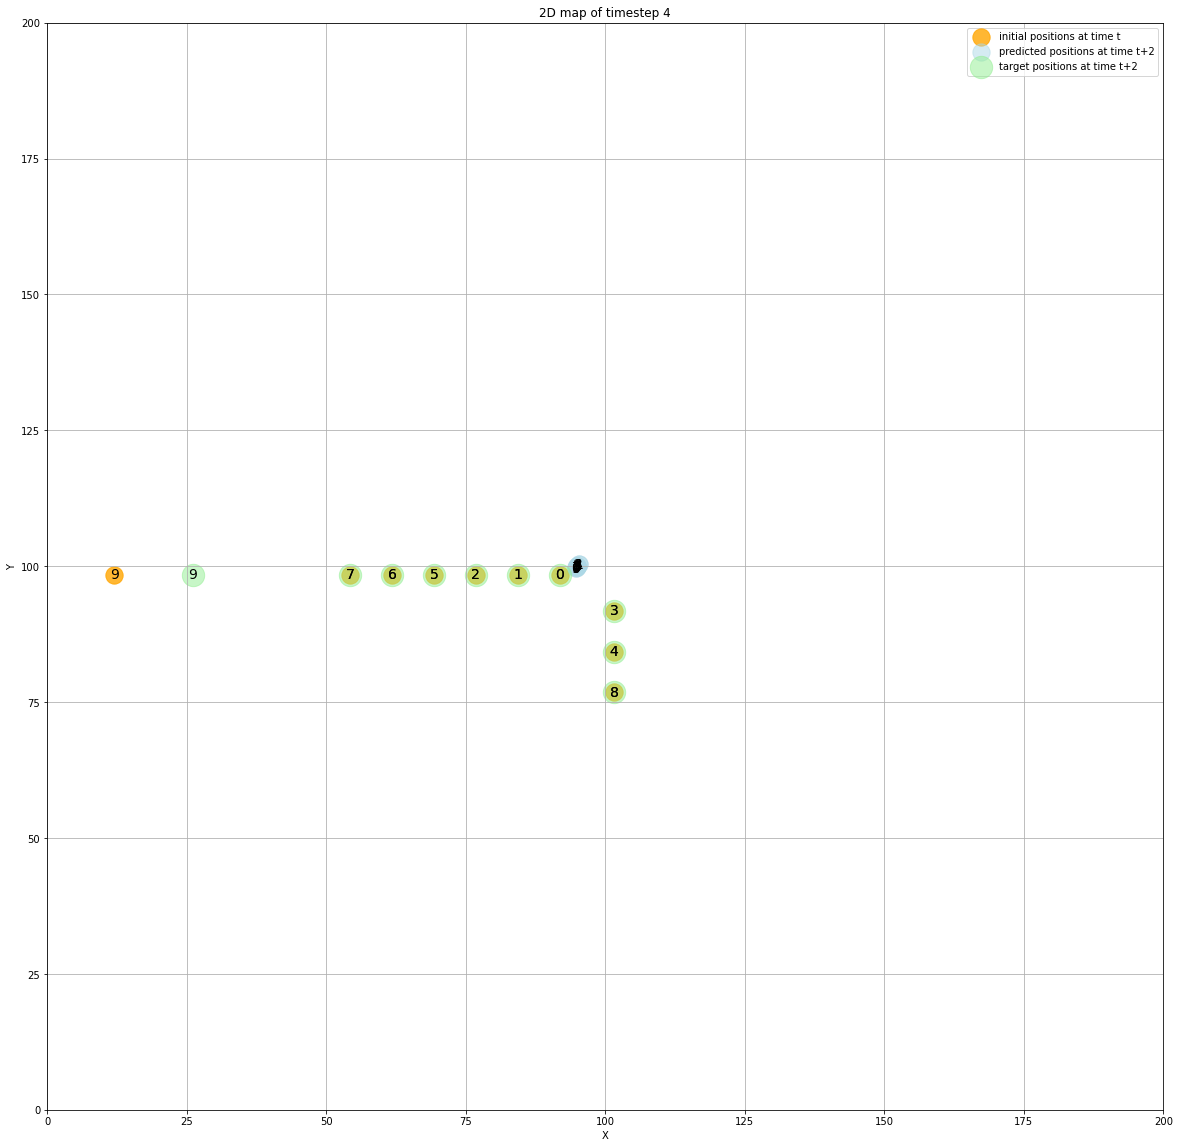

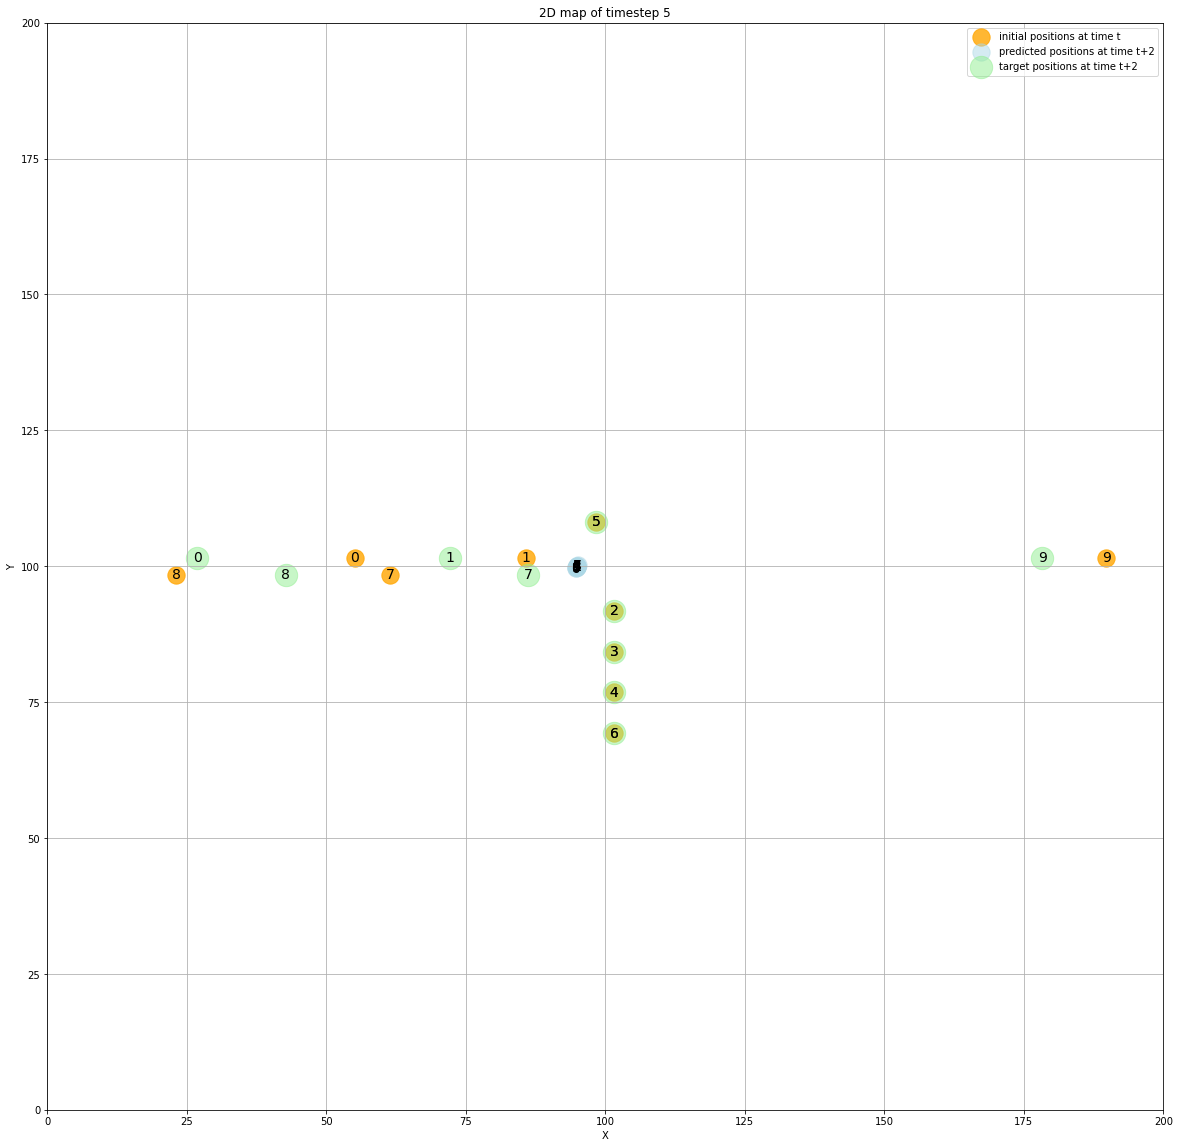

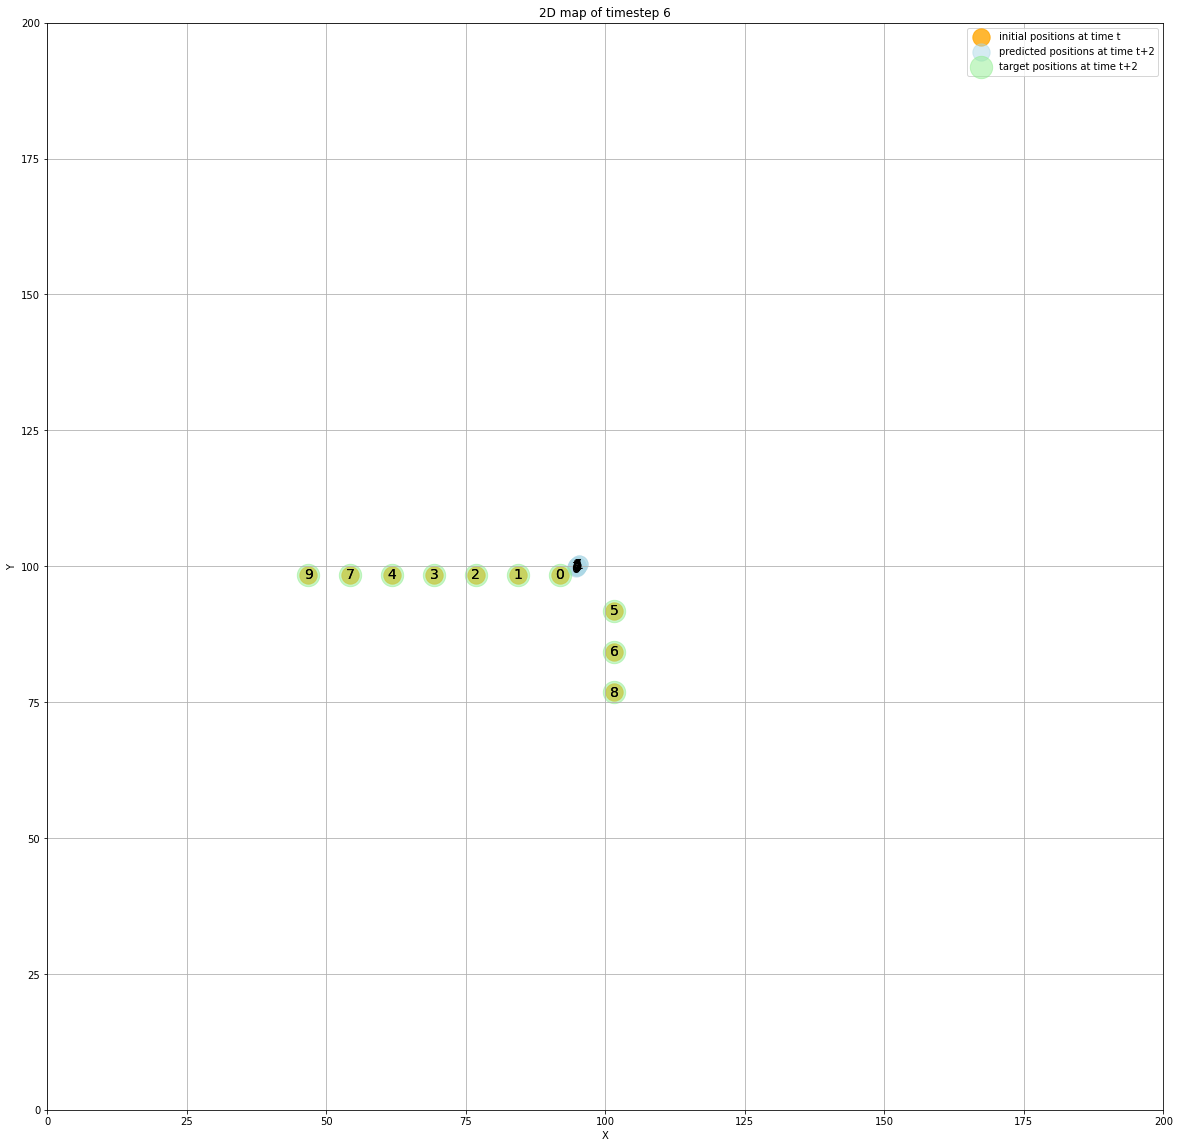

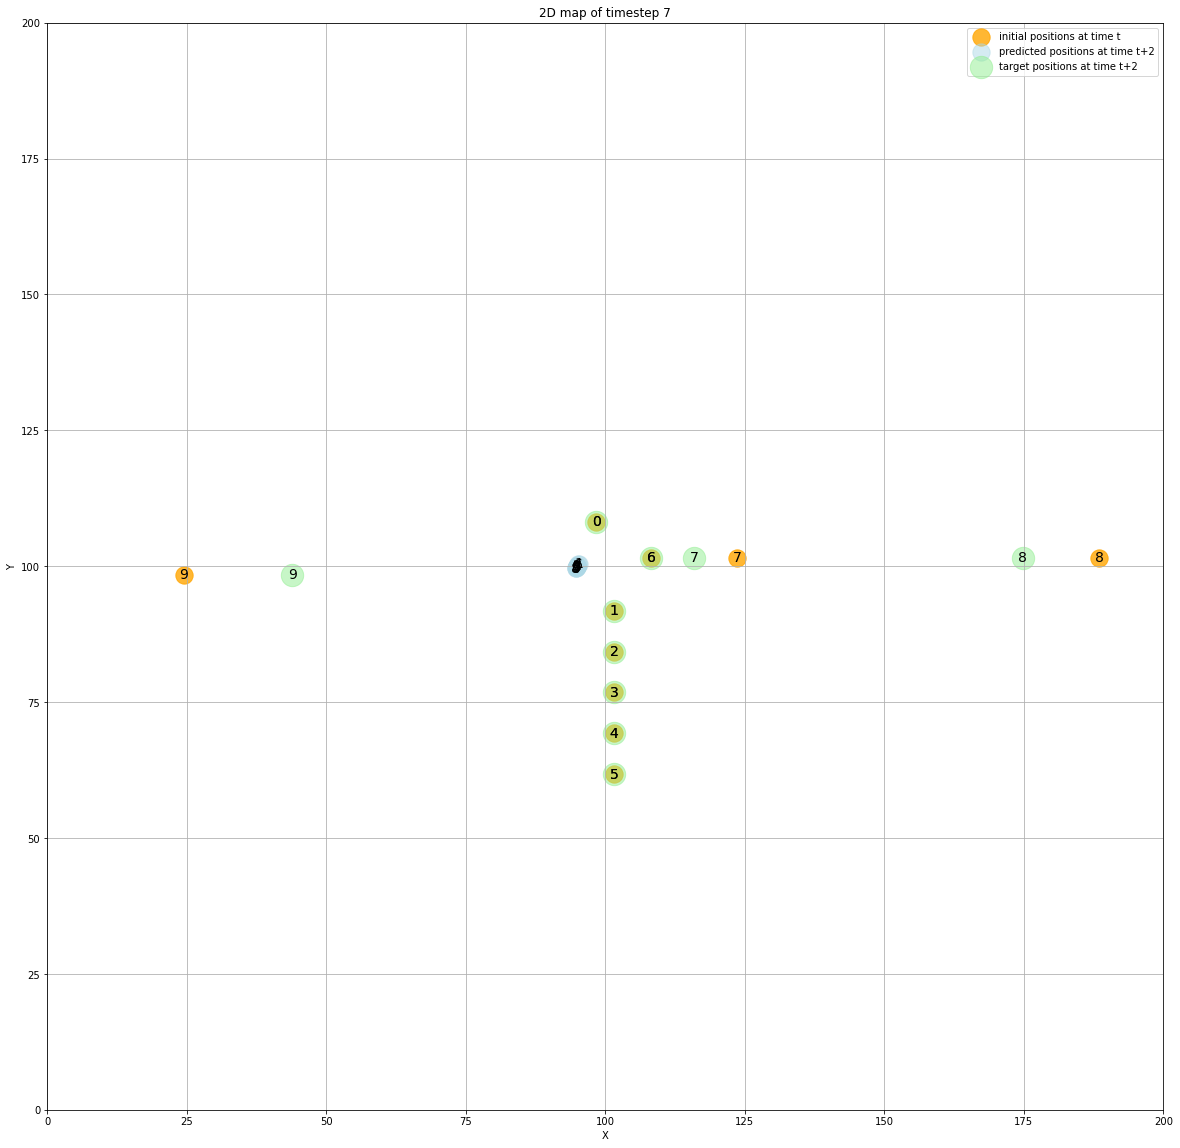

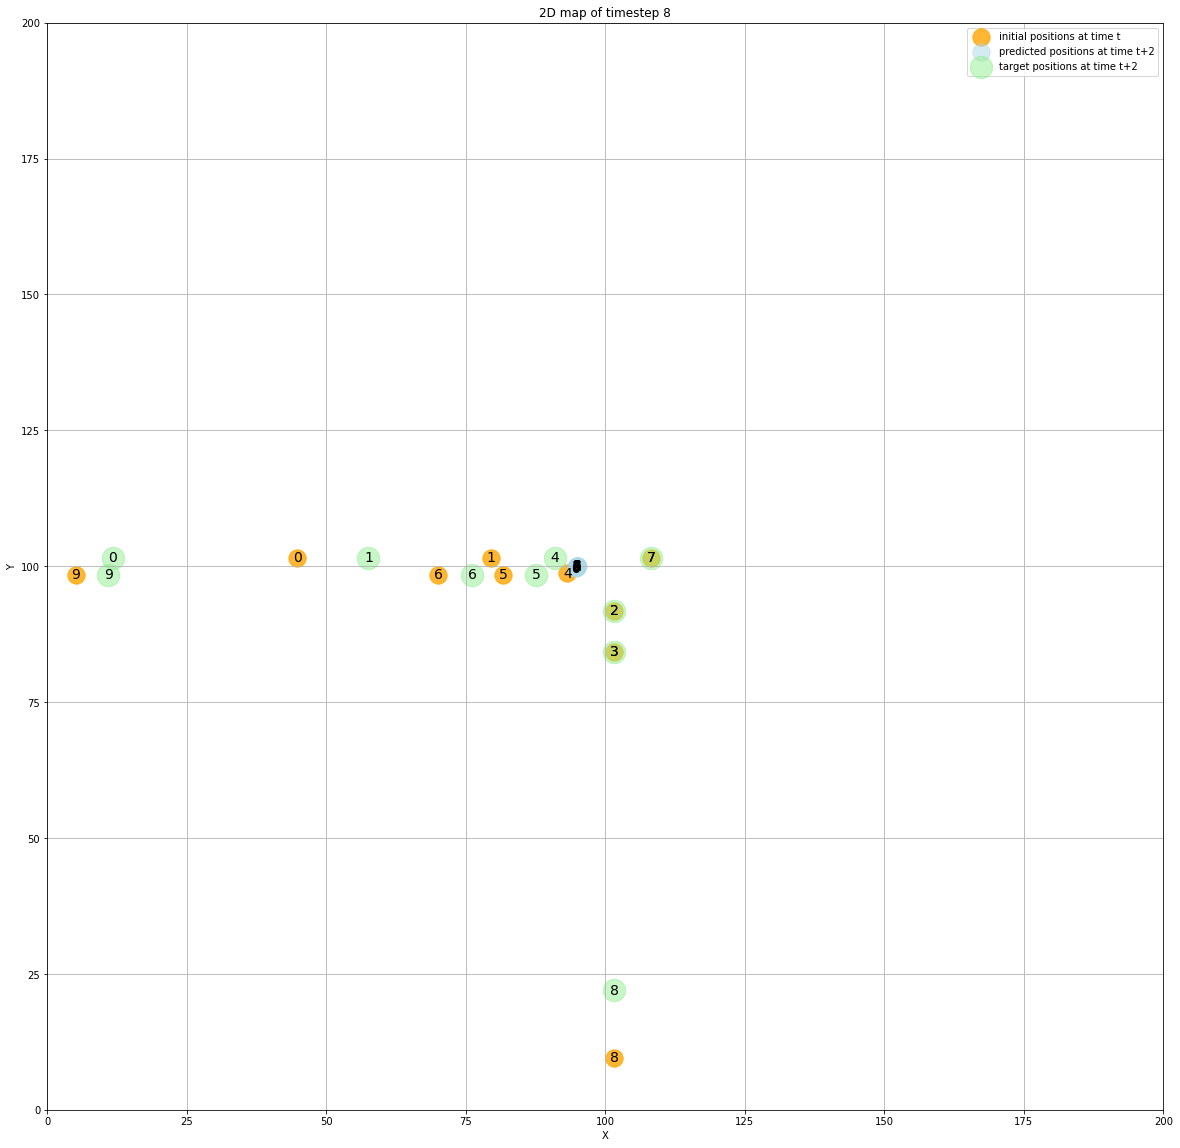

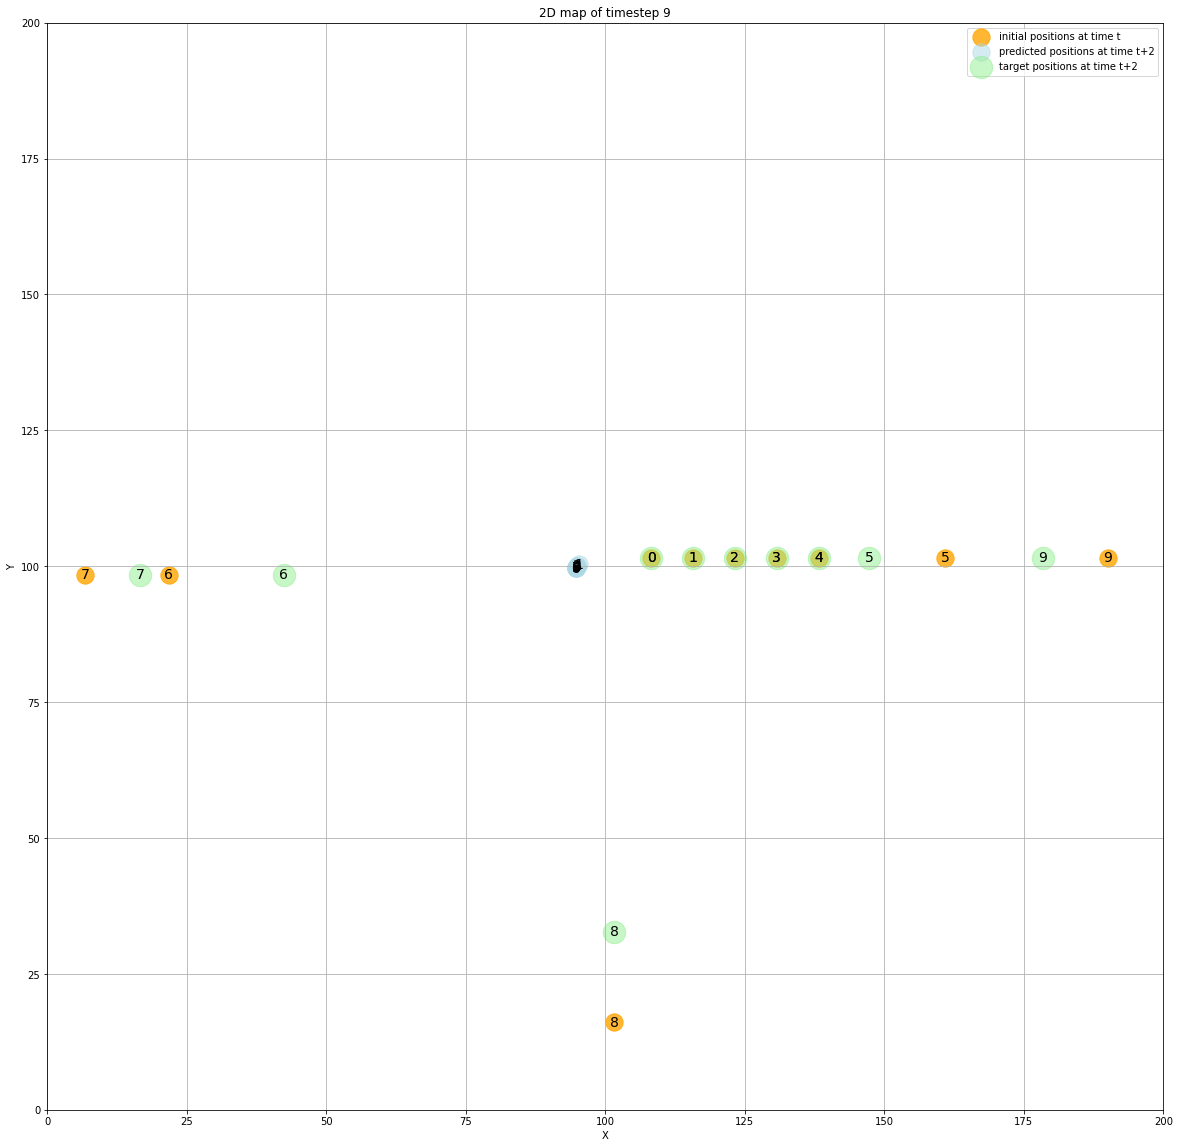

In [37]:
plot_results_model(
                   load_model, 
                   dataset_train,
                   start_from = 0,
                   end_at = 10,
                   edges_attr = True,
                   figsize = (20,20),
                   plot_intention = False
                  )

In [ ]:
deleted_folders = delete_empty_r(directory= OUTPUT_DIR,
                                                 printstat = True)